In [2]:
from qiskit import *
from dotenv import load_dotenv
import os
from qiskit.tools.visualization import plot_histogram
# Load the API key from the .env file
load_dotenv()
IBM_TOKEN = os.getenv('IBM_TOKEN')
IBMQ.save_account(IBM_TOKEN)

IBMQ.load_account()

configrc.store_credentials:WARNING:2023-01-09 07:16:52,447: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
def get_quantum_computer(qubits=2, simulation=False):
    # Finds a quantum computer at IBM with the lowest queue as long as it has enough qubits for the circuit
    if simulation == False: # Execute the circuit on a quantum computer at IBM
        lowest = float('inf')
        provider = IBMQ.get_provider(hub='ibm-q')
        for backend in provider.backends():
            try:
                if "simulator" not in backend.name():
                    queue = backend.status().pending_jobs
                    qubit_count = len(backend.properties().qubits)
                    if qubit_count >= qubits:
                        if queue < lowest:
                            lowest = queue
                            quantum_comp = provider.get_backend(backend.name())
                        print(f"Quantum Computer {backend.name()} has {queue} queued jobs and {qubit_count} qubits")
                    else:
                        print(f"Quantum Computer {backend.name()} has {qubit_count} qubits, but we need {qubits} qubits")
            except:
                print(f"Quantum Computer {backend.name()} is not operational")
        if quantum_comp is None:
            print(f"No Quantum Computers available with {qubits} qubits, using simulator")
    if simulation == True or quantum_comp is None: # Execute the circuit on the simulator
        quantum_comp = Aer.get_backend('qasm_simulator')
    print(f"Using Quantum Computer: {quantum_comp.name()} with {quantum_comp.status().pending_jobs} queued jobs")
    return quantum_comp

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(2)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(2)
# Create a Quantum Circuit
circuit = QuantumCircuit(qr, cr)
# Get a quantum computer with at least the number of selected qubits for the circuit
qc = get_quantum_computer(qubits=circuit.num_qubits, simulation=False)
# Build the circuit
circuit.h(qr[0])
circuit.cx(qr[0], qr[1])
circuit.measure(qr, cr)
circuit.draw()

Quantum Computer ibmq_lima has 0 queued jobs and 5 qubits
Quantum Computer ibmq_belem has 11 queued jobs and 5 qubits
Quantum Computer ibmq_quito has 13 queued jobs and 5 qubits
Quantum Computer ibmq_manila has 67 queued jobs and 5 qubits
Quantum Computer ibm_nairobi has 40 queued jobs and 7 qubits
Quantum Computer ibm_oslo has 15 queued jobs and 7 qubits
Using Quantum Computer: ibmq_lima with 0 queued jobs


┌───┐     ┌─┐   
q5_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q5_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c2: 2/═══════════╩══╩═
                 0  1

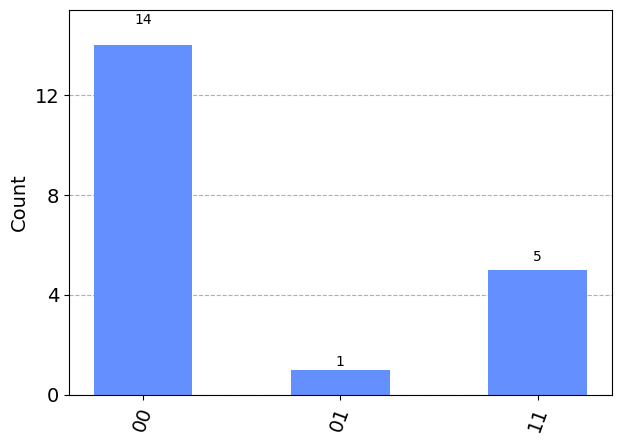

In [6]:
result = execute(circuit, backend=qc, shots=20).result()
plot_histogram(result.get_counts(circuit))
